In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("benalua_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
scaled_X

masked_array(
  data=[[0.30377866873755693],
        [0.2777290842914622],
        [0.24152347535115065],
        [0.2342206951857858],
        [0.20985468680147598],
        [0.1891907328650291],
        [0.2144306887706137],
        [0.17955039063899836],
        [0.1516033305699613],
        [0.14970665204987849],
        [0.16707865431325344],
        [0.16393060041901325],
        [0.22213050972481624],
        [0.20812970247129262],
        [0.24170694546711316],
        [0.26421121479048787],
        [0.31920378923362136],
        [0.4051451445329229],
        [0.5258066621759673],
        [0.6098245232230471],
        [0.6777488324353695],
        [0.7893875393758414],
        [0.7861406349329744],
        [0.7564000424963442],
        [0.7242033909909483],
        [0.7215291558216551],
        [0.7590057748498705],
        [0.7156570204048602],
        [0.6884417028076647],
        [0.665013324133259],
        [0.6046712200940553],
        [0.5683904873737649],
        [0.5296

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

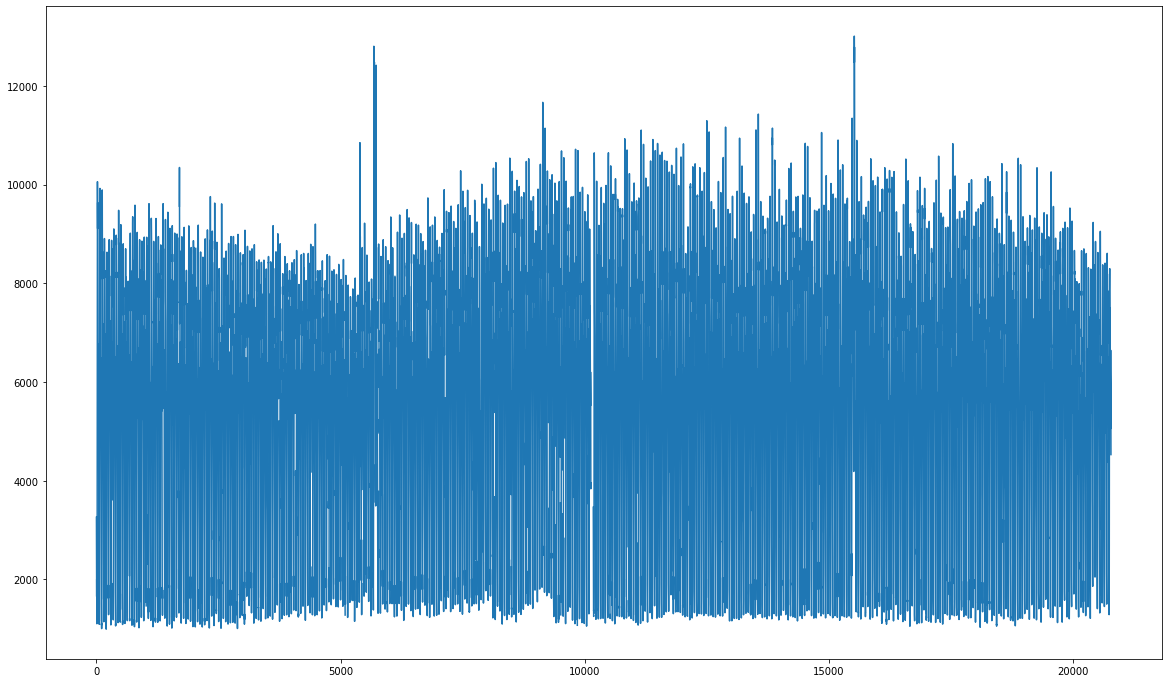

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [10]:
int(0.25*len(scaled_X))

5196

In [11]:
def partitionSet(test_fraction, data, partition):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partition/100)*lenX):int((partition/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partition/100)*lenX)-1],data[int((partition/100)*lenX)+test_size:]))
    train_df[int((partition/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

[train_df,test_df] = partitionSet(0.25,scaled_X, 53)

In [12]:
timesteps = 24

In [13]:
X_train = ma.array([train_df[t:t+timesteps] for t in range(0, len(train_df)-timesteps)])
y_train = train_df[timesteps:, :]
X_test = ma.array([test_df[t:t+timesteps] for t in range(0, len(test_df)-timesteps)]) 
y_test = test_df[timesteps:, :]

In [33]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer='adam')
    X_ = ma.filled(X_train,0)
    Y_ = ma.filled(y_train,0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False)
    return model, MODEL

In [34]:
X_train.shape[1]

24

In [35]:
model, MODEL = LSTM_function(80, X_train.shape[1], 1, 0.05, 200, 256, 0.2)

Epoch 1/200
49/49 [==============================] - 10s 98ms/step - loss: 0.0656 - val_loss: 0.0312
Epoch 2/200
49/49 [==============================] - 3s 64ms/step - loss: 0.0333 - val_loss: 0.0303
Epoch 3/200
49/49 [==============================] - 3s 63ms/step - loss: 0.0330 - val_loss: 0.0300
Epoch 4/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0322 - val_loss: 0.0284
Epoch 5/200
49/49 [==============================] - 3s 67ms/step - loss: 0.0274 - val_loss: 0.0211
Epoch 6/200
49/49 [==============================] - 3s 69ms/step - loss: 0.0197 - val_loss: 0.0154
Epoch 7/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0152 - val_loss: 0.0117
Epoch 8/200
49/49 [==============================] - 3s 63ms/step - loss: 0.0173 - val_loss: 0.0135
Epoch 9/200
49/49 [==============================] - 3s 62ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 10/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0114 - val_loss: 0.008

49/49 [==============================] - 3s 68ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 163/200
49/49 [==============================] - 3s 67ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 164/200
49/49 [==============================] - 3s 68ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 165/200
49/49 [==============================] - 3s 66ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 166/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 167/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 168/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 169/200
49/49 [==============================] - 3s 64ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 170/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 171/200
49/49 [==============================] - 3s 65ms/step - loss: 0.0037 - val_loss: 0

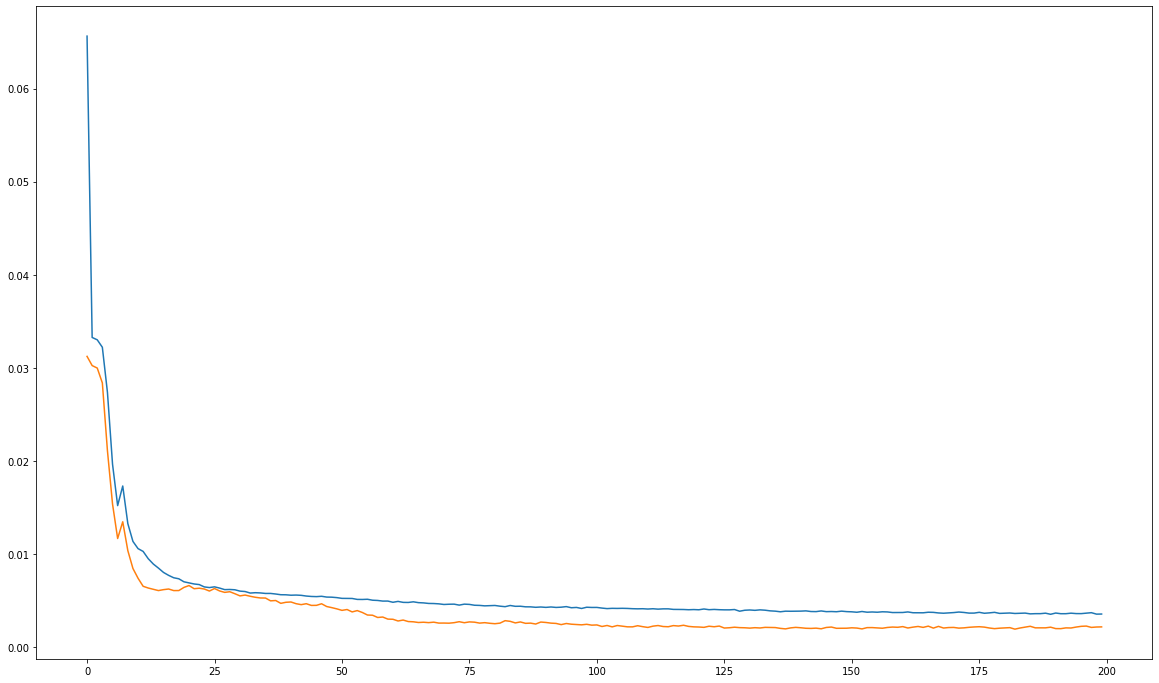

In [36]:
plt.plot(MODEL.history['loss'])
plt.plot(MODEL.history['val_loss'])
plt.show()

In [37]:
prediction_test = model.predict(X_test)

In [38]:
prediction_train = model.predict(X_train)

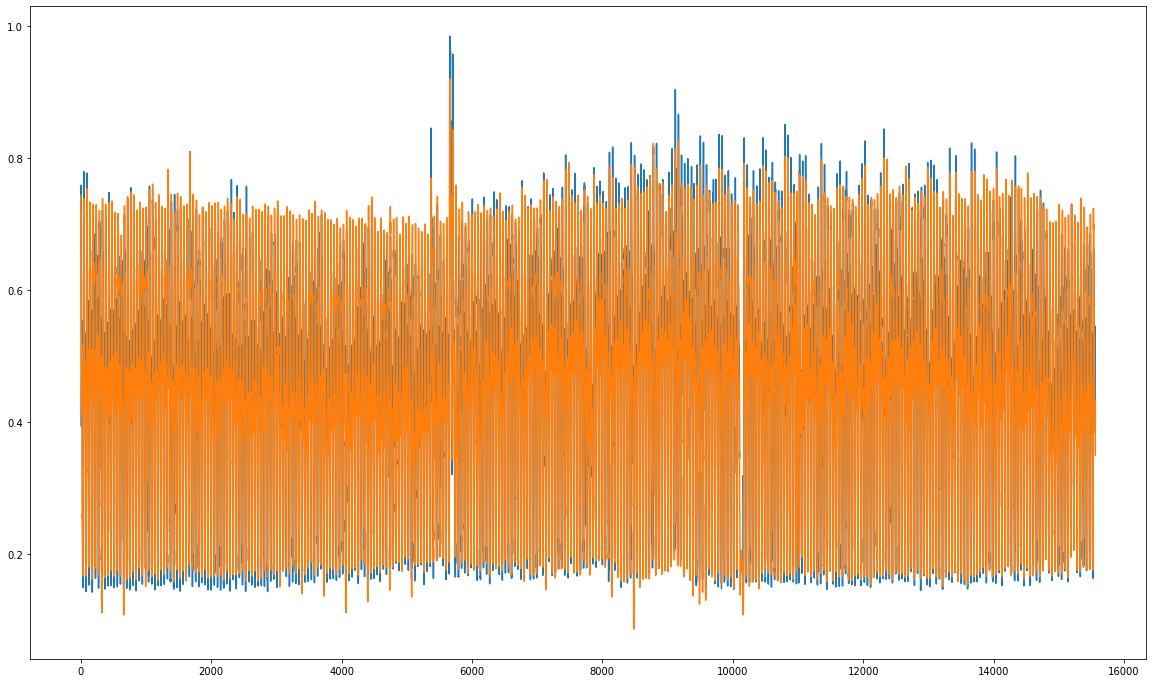

In [39]:
plt.plot(y_train[:,0])
plt.plot(prediction_train[:,0])
plt.show()

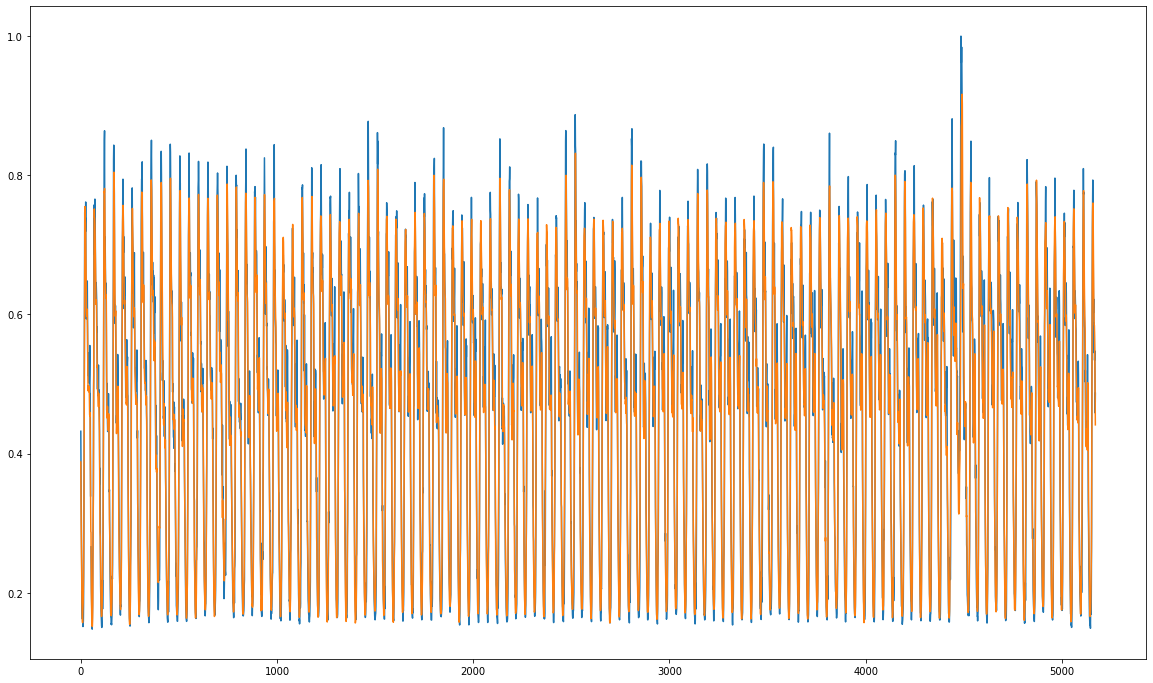

In [40]:
plt.plot(y_test[:,0])
plt.plot(prediction_test[:,0])
plt.show()

In [41]:
inputs = scaled_X[len(scaled_X) - len(test_df) - timesteps:]

In [42]:
inputs

masked_array(
  data=[[0.16867040792424873],
        [0.17306065955541483],
        [0.1672048940401527],
        [0.18979287338081854],
        [0.22531407542553136],
        [0.26626330678077736],
        [0.35630322822355726],
        [0.49271200951940747],
        [0.6384091076608998],
        [0.7444917784687388],
        [0.7817787932634669],
        [0.8137435967376216],
        [0.8490654140000119],
        [0.799449764305238],
        [0.6734501442182819],
        [0.6433509401069774],
        [0.6374624546861726],
        [0.5912629866582546],
        [0.5907262783491742],
        [0.587208970854329],
        [0.5573410925832937],
        [0.5382039686399104],
        [0.4979650489819071],
        [0.43407564324114234],
        [0.42344680374014454],
        [0.4313925706917794],
        [0.4435660089593959],
        [0.46229569113606483],
        [0.5040838212162323],
        [0.5140400783887282],
        [0.5647231625923275],
        [0.5553893315911165],
        [0.5363947

In [43]:
inputs = inputs.reshape(-1,1)

In [44]:
X_test = []

In [45]:
for i in range(24, 360):
    X_test.append(inputs[i-timesteps:i,0])

In [46]:
X_test = np.array(X_test)

In [47]:
X_test.shape

(336, 24)

In [48]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
predicted_demand = model.predict(X_test)

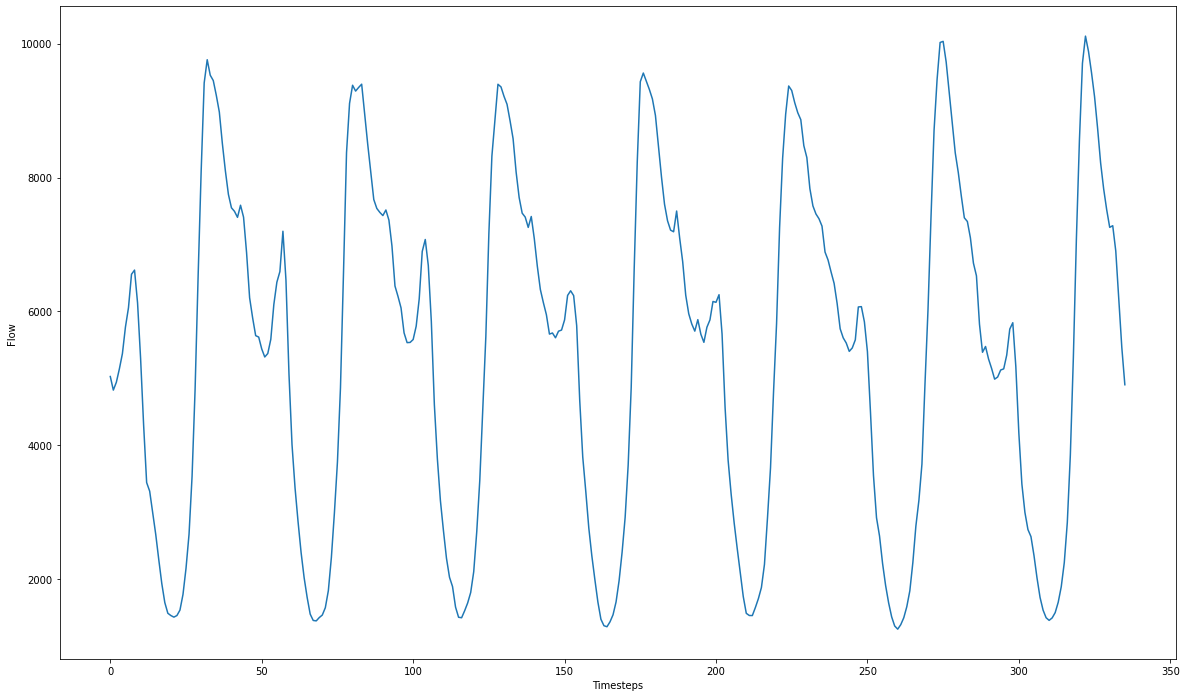

In [51]:
plt.plot(inverse_scaler(predicted_demand, minX, maxX))
plt.xlabel('Timesteps')
plt.ylabel('Flow')
plt.savefig('prediction.jpg')